## Demo:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random
#import cPickle as pickle
import pickle

train_size = 9800
test_size = 200
img_size = 75
size = 5 #Size of the objects in pixels

question_size = 11 ##6 for one-hot vector of color, 2 for question type, 3 for question subtype
"""Answer : [yes, no, rectangle, circle,  r, g, b, o, k, y]"""

nb_questions = 10 #number of question per image
dirs = './data'

colors = [
    (0,0,255),##r
    (0,255,0),##g
    (255,0,0),##b
    (0,156,255),##o
    (128,128,128),##k
    (0,255,255)##y
]

try:
    os.makedirs(dirs)
except:
    print('directory {} already exists'.format(dirs))
    
img = np.ones((img_size,img_size,3)) * 255

def center_generate(objects):
    while True:
        pas = True
        center = np.random.randint(0+size, img_size - size, 2)        
        if len(objects) > 0:
            for name,c,shape in objects:
                if ((center - c) ** 2).sum() < ((size * 2) ** 2):
                    pas = False
        if pas:
            return center

directory ./data already exists


### To add a new figure on sort-of-CLEVR database was necesary to create it _*(cv2.ellipse())*_  as follows:

(-0.5, 74.5, 74.5, -0.5)

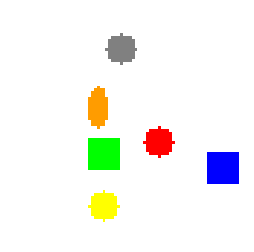

In [3]:
objects = []
img = np.ones((img_size,img_size,3)) * 255
for color_id,color in enumerate(colors):  
    center = center_generate(objects)
    x=random.random()
    #Range chaged: 
    #rectangle if random.random()<0.33, 
    #circle if 0.33<random.random()<0.66, 
    #ellipse ifrandom.random()<0.33
    if x<0.33:
        start = (center[0]-size, center[1]-size)
        end = (center[0]+size, center[1]+size)
        cv2.rectangle(img, start, end, color, -1)
        objects.append((color_id,center,'r'))
    elif x>0.33 and x<0.66:
        center_ = (center[0], center[1])
        cv2.circle(img, center_, size, color, -1)
        objects.append((color_id,center,'c'))
    else:
        center_ = (center[0], center[1])
        axes=(size+2, size-2)
        angle=int(90)
        start=int(0)
        end=int(360)
        cv2.ellipse(img, center_, axes, angle, start, end, color, -1)#New Figure: ellipse
        objects.append((color_id,center,'e'))
plt.imshow(img[:,:,(2,1,0)].astype(np.uint8))
plt.axis('off')

### Then code for question creation also was chaged:
#### First, for non-relational questions, new condition was added in order to insert the new figure in an answer. In this case the position in the answer vector was 4: Answer : [yes, no, rectangle, circle, ellipse r, g, b, o, k, y]

In [4]:
rel_questions = []
norel_questions = []
rel_answers = []
norel_answers = []

#question_size = 11 ##6 for one-hot vector of color, 2 for question type, 3 for question subtype
"""Non-relational questions"""
question = np.zeros((question_size))
color = random.randint(0,5)
question[color] = 1
question[6] = 1
subtype = random.randint(0,2)
question[subtype+8] = 1
"""Answer : [yes, no, rectangle, circle, ellipse r, g, b, o, k, y]"""
if subtype == 0:
    """query shape->rectangle/circle"""
    if objects[color][2] == 'r':
        answer = 2
    elif objects[color][2] == 'c':# Here
        answer = 3
    else:
        answer = 4# and Here
elif subtype == 1:
    """query horizontal position->yes/no"""
    if objects[color][1][0] < img_size / 2:
        answer = 0
    else:
        answer = 1

elif subtype == 2:
    """query vertical position->yes/no"""
    if objects[color][1][1] < img_size / 2:
        answer = 0
    else:
        answer = 1
print(question)
print("color:",color)
print("subtype:",subtype)
print("answer:", answer)

[ 0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.]
color: 1
subtype: 0
answer: 2


#### The same was changed for relational questions. Position 4 in answer vector

In [5]:
#question_size = 11 ##6 for one-hot vector of color, 2 for question type, 3 for question subtype

"""Relational questions"""
question = np.zeros((question_size))
color = random.randint(0,5)
question[color] = 1
question[7] = 1
subtype = random.randint(0,2)
question[subtype+8] = 1
rel_questions.append(question)

if subtype == 0:
    """closest-to->rectangle/circle"""
    my_obj = objects[color][1]
    dist_list = [((my_obj - obj[1]) ** 2).sum() for obj in objects]
    dist_list[dist_list.index(0)] = 999
    closest = dist_list.index(min(dist_list))
    if objects[closest][2] == 'r':
        answer = 2
    elif objects[closest][2] == 'c':# Here
        answer = 3
    else:
        answer = 4# Here
                
elif subtype == 1:
    """furthest-from->rectangle/circle"""
    my_obj = objects[color][1]
    dist_list = [((my_obj - obj[1]) ** 2).sum() for obj in objects]
    furthest = dist_list.index(max(dist_list))
    if objects[furthest][2] == 'r':
        answer = 2
    elif objects[furthest][2] == 'c':# Here
        answer = 3
    else:
        answer = 4# and Here

elif subtype == 2:
    """count->1~6"""
    my_obj = objects[color][2]
    count = -1
    for obj in objects:
        if obj[2] == my_obj:
            count +=1 
    answer = count+4
print(question)
print("color:",color)
print("subtype:",subtype)
print("answer:",answer)

[ 0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.]
color: 4
subtype: 0
answer: 4


### This changes was added to _*sort_of_clevr_generator.py*_ code to generate the entire database. Aditionally, in _*translator.py*_ the answer sheet variable was changed, adding _*'ellipse'*_ in fourth position, according to previous modifications: 

In [6]:
# In translator.py:

#answer_sheet = ['yes', 'no', 'rectangle', 'circle', 'ellipse', '1', '2', '3', '4', '5', '6']

## Now, after training and creating the model (Test set: Relation accuracy=76% and Non-relation accuracy: 99%), is posible to test diferent images:

In [7]:
run main.py

In [8]:
#Loading data
def load_data():
    print('loading data...')
    dirs = './data'
    filename = os.path.join(dirs,'sort-of-clevr.pickle')
    with open(filename, 'rb') as f:
        train_datasets, test_datasets = pickle.load(f)
    rel_train = []
    rel_test = []
    norel_train = []
    norel_test = []
    print('processing data...')

    for img, relations, norelations in train_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_train.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_train.append((img,qst,ans))

    for img, relations, norelations in test_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_test.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_test.append((img,qst,ans))
    
    return (rel_train, rel_test, norel_train, norel_test)

rel_train, rel_test, norel_train, norel_test = load_data()
#Take a few seconds

random.shuffle(rel_train)
random.shuffle(norel_train)
random.shuffle(rel_test)
random.shuffle(norel_test)

def cvt_data_axis(data):
    img = [e[0] for e in data]
    qst = [e[1] for e in data]
    ans = [e[2] for e in data]
    return (img,qst,ans)

rel_train = cvt_data_axis(rel_train)
rel_test = cvt_data_axis(rel_test)
norel_train = cvt_data_axis(norel_train)
norel_test = cvt_data_axis(norel_test)

model = RN(args)

model_dirs = './model'
bs = args.batch_size
input_img = torch.FloatTensor(bs, 3, 75, 75)
input_qst = torch.FloatTensor(bs, 11)
label = torch.LongTensor(bs)

if args.cuda:
    model.cuda()
    input_img = input_img.cuda()
    input_qst = input_qst.cuda()
    label = label.cuda()

input_img = Variable(input_img)
input_qst = Variable(input_qst)
label = Variable(label)

model.train()

def tensor_data(data, i):
    img = torch.from_numpy(np.asarray(data[0][bs*i:bs*(i+1)]))
    qst = torch.from_numpy(np.asarray(data[1][bs*i:bs*(i+1)]))
    ans = torch.from_numpy(np.asarray(data[2][bs*i:bs*(i+1)]))

    input_img.data.resize_(img.size()).copy_(img)
    input_qst.data.resize_(qst.size()).copy_(qst)
    label.data.resize_(ans.size()).copy_(ans)

batch_idx=0 #Normally is "for batch_idx in range(len(rel_train[0]) // bs)"
tensor_data(rel_train, batch_idx)
accuracy_rel = model.train_(input_img, input_qst, label)

tensor_data(norel_train, batch_idx)
accuracy_norel = model.train_(input_img, input_qst, label)

checkpoint = torch.load('model/epoch_RN_20.pth')
model.load_state_dict(checkpoint)

print('READY TO TEST')

loading data...
processing data...
READY TO TEST


NON-RELATIONAL QUESTION
Question orange shape?
[ 0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.]
Answer rectangle
2


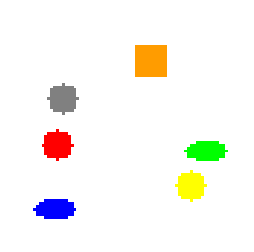

In [9]:
%matplotlib inline
from translator import idx_to_question, idx_to_answer
import matplotlib.pyplot as plt

n = np.random.randint(0,bs)
tensor_data(norel_test, batch_idx)
output = model(input_img, input_qst)
pred = output.data.max(1)[1]
pred2=pred.cpu().numpy()
pred2= np.expand_dims(pred2,axis=1)
pred = torch.from_numpy(pred2)
print("NON-RELATIONAL QUESTION")
plt.imshow((input_img[n].data.cpu().numpy().transpose(1,2,0)[:,:,(2,1,0)]*255).astype(np.uint8))
plt.axis('off')
print("Question",idx_to_question(input_qst[n].data.cpu().numpy()))
print(input_qst[n].data.cpu().numpy())
print("Answer", idx_to_answer(pred[n].cpu().numpy()[0]))
print(pred[n].cpu().numpy()[0])

RELATIONAL QUESTION
Question gray count?
[ 0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.]
Answer 2
6


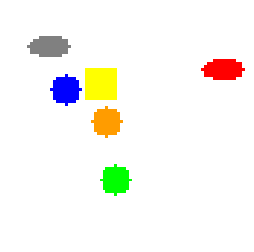

In [10]:
n = np.random.randint(0,bs)
tensor_data(rel_test, batch_idx)
output = model(input_img, input_qst)
pred = output.data.max(1)[1]
pred2=pred.cpu().numpy()
pred2= np.expand_dims(pred2,axis=1)
pred = torch.from_numpy(pred2)
print("RELATIONAL QUESTION")
plt.imshow((input_img[n].data.cpu().numpy().transpose(1,2,0)[:,:,(2,1,0)]*255).astype(np.uint8))
plt.axis('off')
print("Question",idx_to_question(input_qst[n].data.cpu().numpy()))
print(input_qst[n].data.cpu().numpy())
print("Answer", idx_to_answer(pred[n].cpu().numpy()[0]))
print(pred[n].cpu().numpy()[0])